# Aligned residues analysis
*File for analysis of specific aligneg GPCR pair and specific tm*
* use **residues_aligner.p** to obtain data

In [674]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [713]:
res_data = pd.read_csv('aligned_residues.csv')

Text(0.5,0,'residue index')

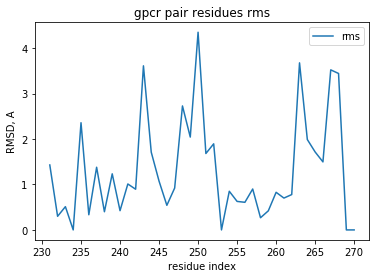

In [714]:
res_data.plot(x = 'resi', y = 'rms')
pylab.title('gpcr pair residues rms')
pylab.ylabel('RMSD, A')
pylab.xlabel('residue index')

## Residue data cleaner

In [715]:
def remove_zeros(X, Y):
    TT = list(X)
    TTT = np.array(Y)
    
    for idx, t in enumerate(TTT):
        if np.isnan(t):
            TTT[idx] = 0
    T = list(TTT)
    
    while T[0] == 0:
        del TT[0]
        del T[0]
    while T[len(T) - 1] == 0:
        del TT[len(TT) - 1]
        del T[len(T) - 1]

    return TT, T

In [716]:
def clear_data(X, Y):
    TT, T = remove_zeros(X, Y)
    for idx, y in enumerate(T):

        if y == -1 or y == 0:
            if (idx - 1) >= 0 and (idx + 1) < len(T):
                if T[idx + 1] != -1 and T[idx + 1] != 0:
                    T[idx] = (T[idx + 1] + T[idx - 1]) / 2.
                else:
                    T[idx] = T[idx - 1]
            elif (idx - 1) > 0:
                T[idx] = T[idx -1]
            elif (idx + 1) < len(T):
                if T[idx + 1] != -1 and T[idx + 1] != 0:
                    T[idx] = T[idx + 1]
                else:
                    T[idx] = [i for i in Y if i > 0][0]
    return TT, T

Text(0.5,0,'residue index')

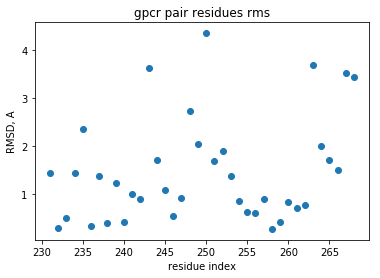

In [717]:
X, Y = clear_data(res_data['resi'], res_data['rms'])
pylab.scatter(X, Y)
pylab.title('gpcr pair residues rms')
pylab.ylabel('RMSD, A')
pylab.xlabel('residue index')

## Residue data smoother

In [718]:
def smooth_data(X, Y, step):
    sum_rms = []
    T = zip(X, Y)
    for idx, t in enumerate(T):
        if (idx + step - 1) < len(Y):
            s = sum(Y[idx:idx + step]) / float(step)
            sum_rms.append([t[0], s])
            
            x = [i[0] for i in sum_rms]
            y = [i[1] for i in sum_rms]
    return x, y

In [719]:
def exponential_smooth(X, Y, step):
    sum_rms = []
    T = zip(X, Y)
    for idx, t in enumerate(T):
        if idx == 0:
            s = Y[idx]
            sum_rms.append([t[0], s])
        else:
            s = sum_rms[idx - 1][1] + float(step) * (Y[idx] - sum_rms[idx - 1][1])
            sum_rms.append([t[0], s])
            
            x = [i[0] for i in sum_rms]
            y = [i[1] for i in sum_rms]
    return x, y

Text(0,0.5,'RMSD, A')

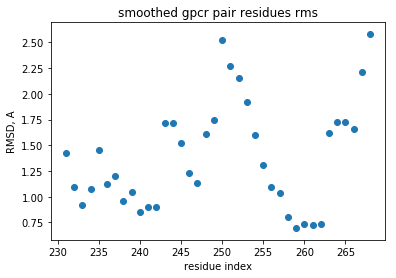

In [720]:
sm_X, sm_Y = exponential_smooth(X, Y, 0.3)

pylab.scatter(sm_X, sm_Y)
pylab.title('smoothed gpcr pair residues rms')
pylab.xlabel('residue index')
pylab.ylabel('RMSD, A')

## Determine residue index, which corresponds to minimal rmsd

In [721]:
def get_extremums(X, Y):
    x = np.array(X)
    y = np.array(Y)
    
    maxm = argrelextrema(y, np.greater)[0]
    minm = argrelextrema(y, np.less)[0]
    x_maxm = [x + X[0] for x in maxm]
    x_minm = [x + X[0] for x in minm]
    y_maxm = []
    y_minm = []
    
    for i, j in zip(X, Y):
        if i in x_maxm:
            y_maxm.append(j)
        elif i in x_minm:
            y_minm.append(j)
            
    return x_maxm, y_maxm, x_minm, y_minm
    

In [722]:
def get_min_resi(sm_X, sm_Y):
    y_min = min(sm_Y)
    
    for x, y in zip(sm_X, sm_Y):
        if y == y_min:
            return x

In [723]:
x_maxm, y_maxm, x_minm, y_minm = get_extremums(sm_X, sm_Y)
print 'maximums are:'
for maxm in zip(x_maxm, y_maxm):
    print maxm
print '\nminimums are:'
for minm in zip(x_minm, y_minm):
    print minm

gl_min_y = min(y_minm)
gl_min_x = [x[0] for x in zip(x_minm, y_minm) if x[1] == gl_min_y][0]

print '\nglobal minimum is:'
print gl_min_x, gl_min_y

maximums are:
(235.0, 1.4585542605936526)
(237.0, 1.1985689908309578)
(239.0, 1.041595411094175)
(241.0, 0.9026236910404281)
(243.0, 1.713785769303932)
(250.0, 2.5249174015569165)
(260.0, 0.7324132519542916)
(264.0, 1.731315639338781)

minimums are:
(233.0, 0.916918231844902)
(236.0, 1.1210778483384847)
(238.0, 0.9589922425181329)
(240.0, 0.8561584465250396)
(242.0, 0.900451662654386)
(247.0, 1.1355515270259446)
(259.0, 0.6915099816066514)
(261.0, 0.7229287225311817)
(266.0, 1.6576724265950182)

global minimum is:
259.0 0.6915099816066514


### Determine best point considering slope

In [724]:
x_maxm, y_maxm, x_minm, y_minm = get_extremums(sm_X, sm_Y)
diff = []
for y in y_minm:
    idx = sm_Y.index(y)
    d = sm_Y[idx + 1] - y
    if d < 0.05:
        d = sm_Y[idx + 2] - y
        if d < 0.05:
            d = sm_Y[idx + 3] - y
    diff.append(d)
    
max_diff = max(diff)
idx = diff.index(max_diff)

gl_min_y = y_minm[idx]
gl_min_x = x_minm[idx]

print 'global minimum is:'
print gl_min_x, gl_min_y

[0.15562313085794444, 0.07749114249247313, 0.08260316857604211, 0.8576273227788924, 0.813334106649546, 0.47797320041577596, 0.04798809908544854, 0.8978472704553634, 0.5594898398239239]
global minimum is:
261.0 0.7229287225311817


In [725]:
x_maxm, y_maxm, x_minm, y_minm = get_extremums(sm_X, sm_Y)
diff = []
for x_min, y_min in zip(x_minm, y_minm):
    for x_max, y_max in zip(x_maxm, y_maxm):
        if x_max > x_min:
            diff.append(y_max - y_min)
            break
        else:
            continue
max_diff = max(diff)
idx = diff.index(max_diff)

gl_min_y = y_minm[idx]
gl_min_x = x_minm[idx]

print 'global minimum is:'
print gl_min_x, gl_min_y

global minimum is:
247.0 1.1355515270259446
